In [ ]:
import requests
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

API_KEY = "ca72e792bc6e44b4be1230936250904"
CITY = "Karachi"
BASE_URL = f"http://api.weatherapi.com/v1/history.json?key={API_KEY}&q={CITY}&dt="

dates = pd.date_range(end=pd.to_datetime('today'), periods=30).strftime('%Y-%m-%d')

weather_data = []

print("Fetching weather data...")
for date in dates:
    url = BASE_URL + date
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'forecast' in data:
            day_data = data['forecast']['forecastday'][0]['day']
            weather_data.append({
                "date": date,
                "maxtemp_c": day_data.get("maxtemp_c"),
                "humidity": day_data.get("avghumidity"),
                "wind_kph": day_data.get("maxwind_kph"),
                "pressure_mb": day_data.get("avgvis_km"),
                "cloud": day_data.get("daily_chance_of_rain", 0),
                "visibility_km": day_data.get("avgvis_km")
            })

weather_df = pd.DataFrame(weather_data)

weather_df.dropna(inplace=True)

print(f"\nData shape after cleanup: {weather_df.shape}")

X = weather_df[["maxtemp_c", "humidity", "wind_kph", "pressure_mb", "cloud", "visibility_km"]].values

from sklearn.preprocessing import StandardScaler

model = GaussianHMM(n_components=5, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X)

print("\nPredicting next day...")
last_state = model.predict([X[-1]])[0]
predicted_vals = []

for _ in range(7):
    next_state = np.random.choice(np.arange(model.n_components), p=model.transmat_[last_state])
    next_mean = model.means_[next_state]
    predicted_vals.append(next_mean)
    last_state = next_state

future_dates = pd.date_range(start=datetime.today() + timedelta(days=1), periods=7).strftime('%Y-%m-%d')
predicted_df = pd.DataFrame(predicted_vals, columns=["maxtemp_c", "humidity", "wind_kph", "pressure_mb", "cloud", "visibility_km"])
predicted_df["date"] = future_dates

weather_df["type"] = "Actual"
predicted_df["type"] = "Predicted"
full_df = pd.concat([weather_df[["date", "maxtemp_c", "humidity", "wind_kph", "pressure_mb", "cloud", "visibility_km", "type"]],
                     predicted_df], ignore_index=True)

print("Next-Day Weather Forecast (Predicted):\n")
for idx, row in predicted_df.iterrows():
        print(f"{row['date']}:")
        print(f"  Temperature     : {row['maxtemp_c']:.2f} °C")
        print(f"  Humidity        : {row['humidity']:.2f} %")
        print(f"  Wind Speed      : {row['wind_kph']:.2f} kph")
        print(f"  Pressure        : {row['pressure_mb']:.2f} mb")
        print(f"  Cloudiness      : {row['cloud']:.2f} %")
        print(f"  Visibility      : {row['visibility_km']:.2f} km\n")

Fetching weather data...

Data shape after cleanup: (30, 7)

Predicting next day...
Next-Day Weather Forecast (Predicted):

2025-04-15:
  Temperature     : 32.90 °C
  Humidity        : 27.33 %
  Wind Speed      : 21.90 kph
  Pressure        : 10.00 mb
  Cloudiness      : 0.00 %
  Visibility      : 10.00 km

2025-04-16:
  Temperature     : 33.23 °C
  Humidity        : 33.02 %
  Wind Speed      : 19.42 kph
  Pressure        : 10.00 mb
  Cloudiness      : 0.00 %
  Visibility      : 10.00 km

2025-04-17:
  Temperature     : 32.90 °C
  Humidity        : 27.33 %
  Wind Speed      : 21.90 kph
  Pressure        : 10.00 mb
  Cloudiness      : 0.00 %
  Visibility      : 10.00 km

2025-04-18:
  Temperature     : 33.23 °C
  Humidity        : 33.02 %
  Wind Speed      : 19.42 kph
  Pressure        : 10.00 mb
  Cloudiness      : 0.00 %
  Visibility      : 10.00 km

2025-04-19:
  Temperature     : 34.57 °C
  Humidity        : 54.80 %
  Wind Speed      : 19.08 kph
  Pressure        : 10.00 mb
  Cloudi

c:\Users\Tesla Laptops\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Tesla Laptops\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


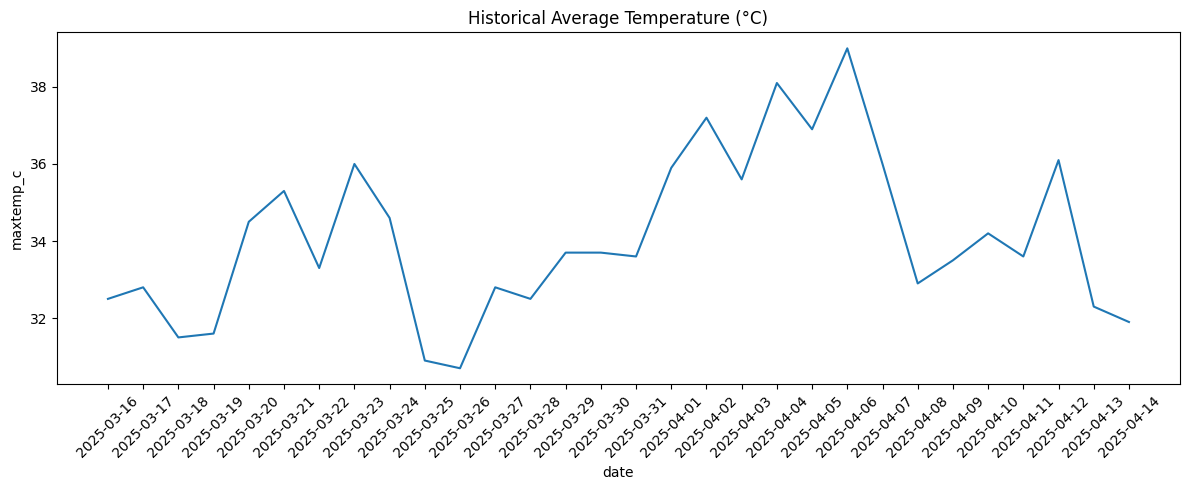

In [42]:
import seaborn as sns

# Check actual avg temps over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=weather_df, x="date", y="maxtemp_c")
plt.title("Historical Average Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


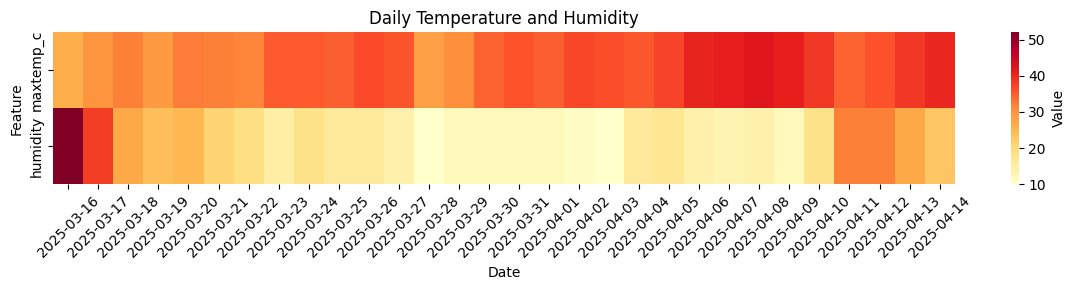

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare a small, clean dataset
heat_df = weather_df[["date", "maxtemp_c", "humidity"]].copy()
heat_df.set_index("date", inplace=True)

# Transpose so each row is a feature, each column is a date
heat_df = heat_df.T

# Plot heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(heat_df, cmap="YlOrRd", cbar_kws={'label': 'Value'})
plt.title("Daily Temperature and Humidity")
plt.ylabel("Feature")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



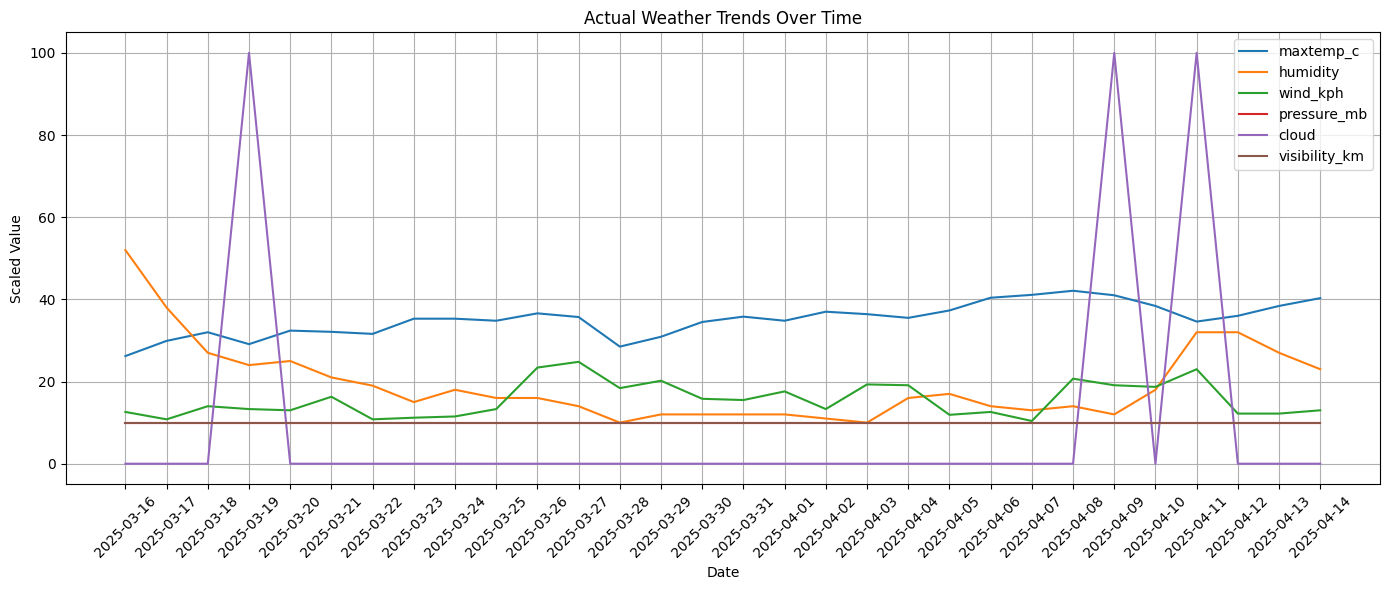

In [47]:
plt.figure(figsize=(14, 6))
for col in ["maxtemp_c", "humidity", "wind_kph", "pressure_mb", "cloud", "visibility_km"]:
    plt.plot(weather_df["date"], weather_df[col], label=col)

plt.title("Actual Weather Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


c:\Users\Tesla Laptops\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Tesla Laptops\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Tesla Laptops\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


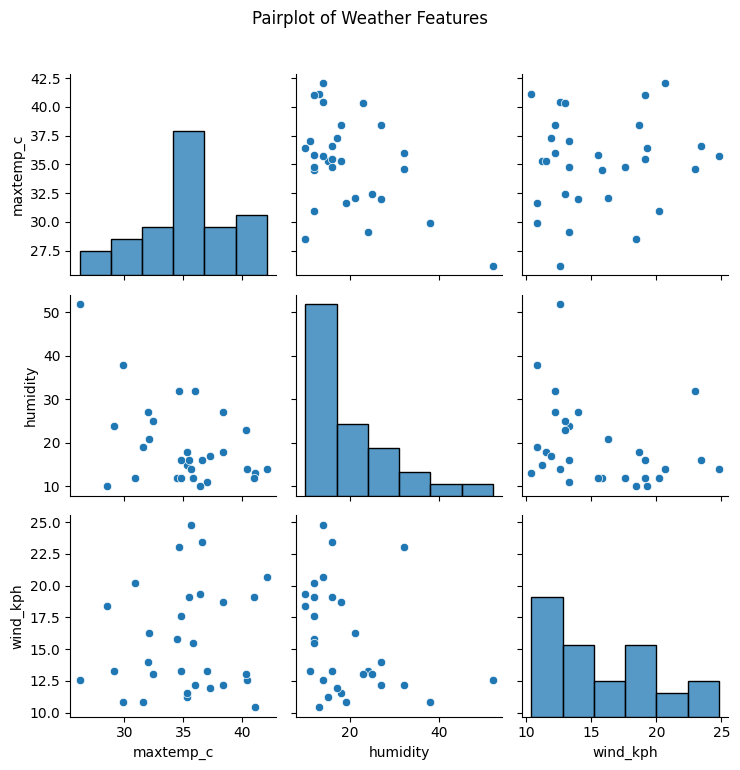

In [58]:
sns.pairplot(weather_df[["maxtemp_c", "humidity", "wind_kph"]])
plt.suptitle("Pairplot of Weather Features", y=1.02)
plt.tight_layout()
plt.show()


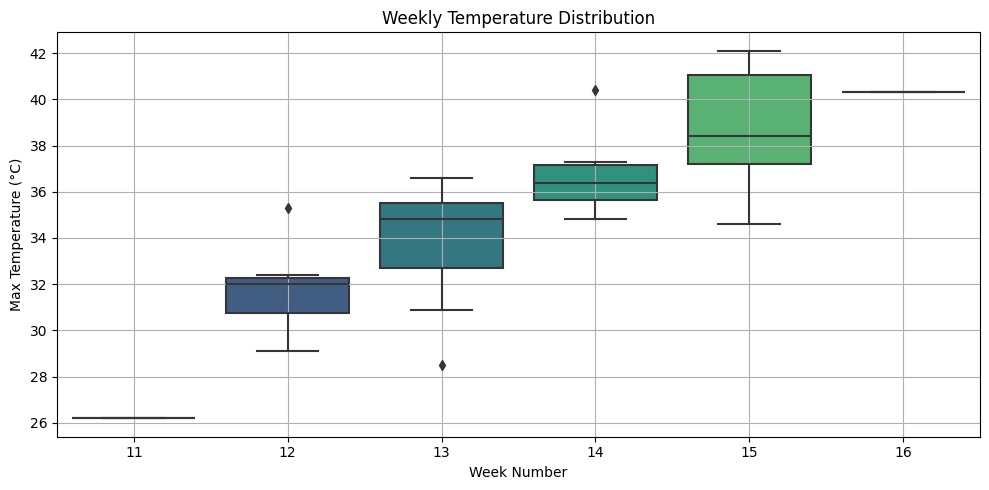

In [59]:
weather_df["week"] = weather_df["date"].dt.isocalendar().week

plt.figure(figsize=(10, 5))
sns.boxplot(data=weather_df, x="week", y="maxtemp_c", palette="viridis")
plt.title("Weekly Temperature Distribution")
plt.xlabel("Week Number")
plt.ylabel("Max Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()
